# Computational Cytometry

`Cytoflow` includes modules and views for analyzing and visualizing high-dimensional data from flow cytometry experiments. Often called *computational cytometry*, these semi-supervised and unsupervised analysis pipelines are generally broken into three major pieces:

1. **Clean and pre-process the data**. Check for tubes that have artifacts / discontinuities in the flow rate, for example, and then compensate for spill-over between channels. Possibly warp the channels between tubes to bring peaks into registration. Because these data are pre-processed, those capabilities are not demonstrated here, but see the `BleedthroughLinearOp`, `FlowCleanOp` and `RegistrationOp` classes for details on how to perform these cleaning steps.

<div class="alert alert-block alert-warning">
Often, pre-processing also involves scaling data with a log or biexponential scaling function. However, `Cytoflow` maintains the underlying data in its unscaled form, and scales it as needed for processing or visualization.
</div>

2. **Cluster or reduce the dimensionality of the data**. Cytoflow includes several clustering algorithms -- KMeans, FlowPeaks, and self-organizing maps -- and two dimensionality reduction methods, principle components analysis and t-distributed stochastic neighbor embedding. Self-organizing maps and tSNE are demonstrated below.

3. **Visualize the data to explore the biology.** For dimensionality-reduction methods like tSNE and PCA, standard scatterplots are used. However, for high-dimensional clustering, a minimum-spanning tree has become common. `Cytoflow` allows a user to create both visualizations, and each is demonstrated below as well.

This notebook demonstrates self-organized maps (SOM), minimum-spanning trees, and t-distributed stochastic neighbor embedding (t-SNE) using data from `Saeys Y, Van Gassen S, Lambrecht BN. Computational flow cytometry: helping to make sense of high-dimensional immunology data. Nature Reviews Immunology 16:449-462 (2016)`. The methods below reproduce many of the figures from that paper. (It's a great paper -- go read it!)

The example data files are taken from the `Hierarchical Gating` example notebook, which applied manual gating to identify NK, NK T, T and B cells; neutrophils, DCs, basophils, and macrophages. (After running the operations in that notebook, I used the `ExportFCS` operation to export each different cell type in a different .FCS file.) These manual gates serve as the "ground truth" to evaluate the performance of the clustering, dimensionality reduction, and visualization algorithms. 

## Set up the notebook and import the data set

In [1]:
import cytoflow as flow
import pandas as pd

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

We have a single "tube" metadata, which is the cell type from the (manual) hierarchical gating.

In [2]:
import_op = flow.ImportOp(conditions = {"Cell_Type" : "category"},
                          tubes = [flow.Tube(file='B Cell.fcs', conditions = {"Cell_Type" : "B Cell"}), 
                                   flow.Tube(file='Basophil.fcs', conditions = {"Cell_Type" : "Basophil"}),
                                   flow.Tube(file='DC.fcs', conditions = {"Cell_Type" : "DC"}),
                                   flow.Tube(file='Macrophage.fcs', conditions = {"Cell_Type" : "Macrophage"}),
                                   flow.Tube(file='Neutrophil.fcs', conditions = {"Cell_Type" : "Neutrophil"}),
                                   flow.Tube(file='NK T.fcs', conditions = {"Cell_Type" : "NK T"}),
                                   flow.Tube(file='NK.fcs', conditions = {"Cell_Type" : "NK"}),
                                   flow.Tube(file = "T Cell.fcs", conditions = {"Cell_Type" : "T Cell"})],
                          channels = {"FSC-A" : "FSC_A",
                                      "FSC-H" : "FSC_H",
                                      "FSC-W" : "FSC_W",
                                      "APC-Cy7-A" : "Live_Dead",
                                      "AmCyan-A" : "AmCyan",
                                      "BV711-A" : "CD64",
                                      "PE-A" : "CD3",
                                      "PE-Cy5-A" : "CD19",
                                      "APC-A" : "CD161",
                                      "PE-Cy7-A" : "CD11c",
                                      "PerCP-Cy5-5-A" : "MHCII",
                                      "Alexa Fluor 700-A" : "Ly_6G",
                                      "BV605-A" : "CD11b",
                                      "BV786-A" : "FcERI",
                                      "Pacific Blue-A" : "Pacific_Blue",
                                      "Time" : "Time"})

ex_import = import_op.apply()

The exported FCS files were not pre-gated to remove debris and clumps. Instead of using a manual gate, let's use a `DensityGateOp` gate on `FSC_H` and `FSC_W` to select 80% of the events in the densest clusters. It's more reproducible and less biased than manual gating!

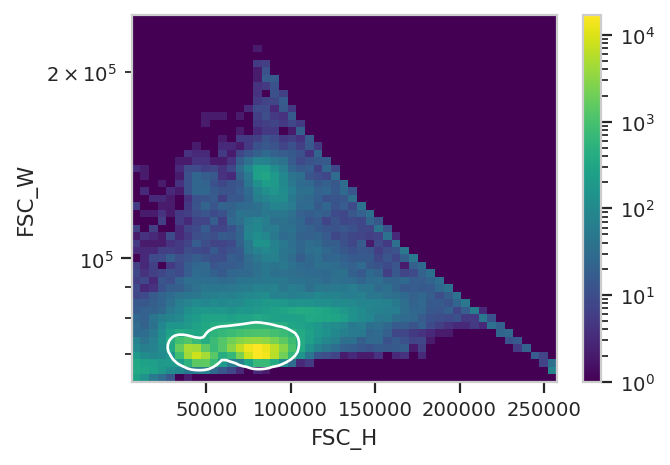

In [3]:
density_op = flow.DensityGateOp(name = "Single_Cell",
                                xchannel = "FSC_H",
                                ychannel = "FSC_W",
                                yscale = "log",
                                keep = 0.8)
density_op.estimate(ex_import)
density_op.default_view(huescale = "log").plot(ex_import)

In [4]:
ex_single_cell = density_op.apply(ex_import)

That said, a single `RangeOp` gate makes it pretty easy to sort out the live cells (**Live_Dead-**) from the dead cells (**Live_Dead+**)

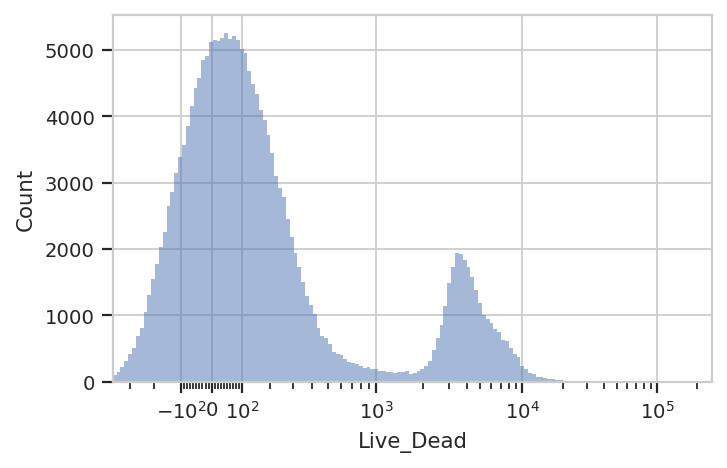

In [5]:
flow.HistogramView(channel = "Live_Dead",
                   scale = "logicle",
                   subset = "Single_Cell == True").plot(ex_single_cell)

In [6]:
ex_live = flow.RangeOp(name = "Live",
                       channel = "Live_Dead",
                       low = -300,
                       high = 1000).apply(ex_single_cell)

## Clustering with Self-Organizing Maps

SOMs use a grid of interconnected "neurons" to that are trained to categorize high-dimensional inputs. For a reasonable panel like the 9-marker panel we're using, the default settings seem to be fine, but there are a *lot* of other parameters that can be tweaked. See the `SOMOp` documentation for details. I also highly suggest reading https://rubikscode.net/2018/08/20/introduction-to-self-organizing-maps/ and https://www.datacamp.com/tutorial/self-organizing-maps -- the **Tuning the SOM Model** section in that second link is particularly helpful!

We use `SOMOp` just like any other data-driven module -- instantiate the module, then call `estimate()`. This one can take a minute or so on a decent computer, so be patient. This algorithm also works substantially better on scaled data, so we'll scale each channel with the `logicle` biexponential scale before training the map.

In [7]:
som_op = flow.SOMOp(name = "SOM_Cluster",
                    channels = ["CD64",
                                "CD3",
                                "CD19",
                                "CD161",
                                "CD11c",
                                "MHCII",
                                "Ly_6G",
                                "CD11b",
                                "FcERI"],
                    scale = {"CD64" : "logicle",
                             "CD3" : "logicle",
                             "CD19" : "logicle",
                             "CD161" : "logicle",
                             "CD11c" : "logicle",
                             "MHCII" : "logicle",
                             "Ly_6G" : "logicle",
                             "CD11b" : "logicle",
                             "FcERI" : "logicle"})
som_op.estimate(ex_live, subset = "Single_Cell == True & Live == True")

/home/brian/src/cytoflow/cytoflow/utility/minisom.py:645: RuntimeWarning: invalid value encountered in sqrt


In this example, we know the ground truth, but in general we won't -- so we need to use *internal* measures to evaluate the performance of our classifier. In this case, `default_view()` creates a diagnostic view so we can get a sense of how well the training went. The top plot is a *distance map*, where each cell represents one neuron and the color represents how close the neuron is to its adjacent neurons. Think of it as a topographic map -- the input data will cluster in the "valleys". In this case, we can see that there are two major "valleys" -- we'll see later if those correspond to any major cell types.

The other plot that `default_view()` gives you is a plot of the quantization error over the training epochs. Lower quantization error means the model fits the data better. This should decrease, but it pretty much always looks asymptotic. If it doesn't seem to have decreased much, increase the number of iterations, but beware -- later iterations give you less of a decrease each time than earlier ones!

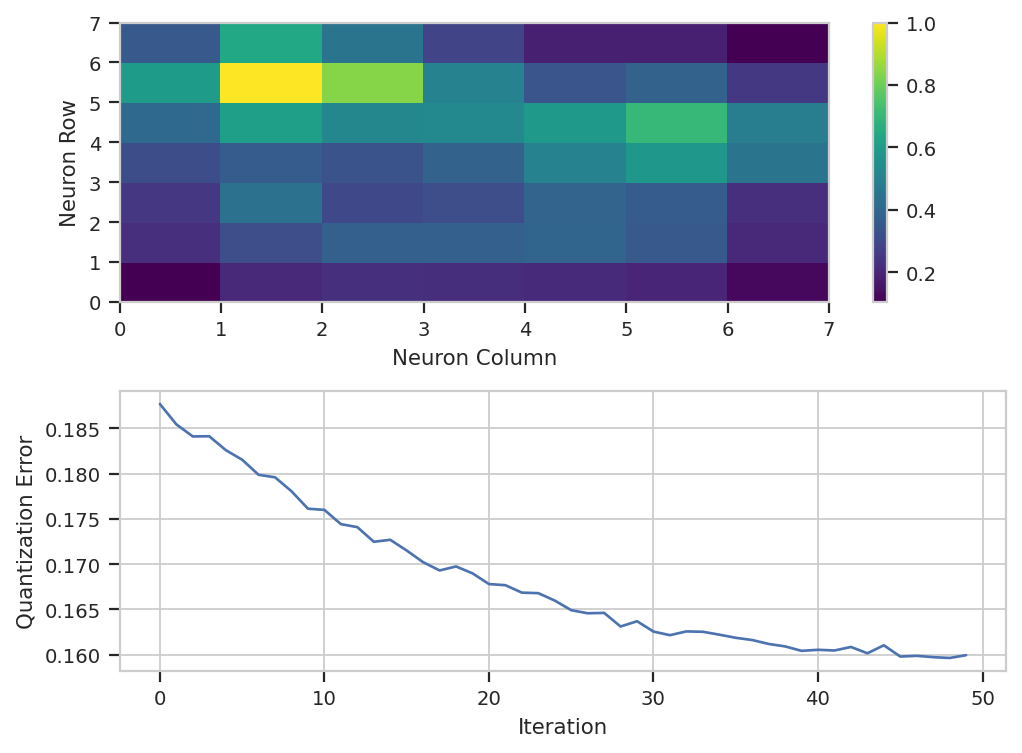

In [8]:
som_op.default_view().plot(ex_live)

Let's apply the classifier.

In [9]:
ex_som = som_op.apply(ex_live)

To use `SOMOp` effectively, it's important to understand what exactly it did. First, it added a statistic with the same name as the operation. Each row is a cluster and each column is one of the channels the model was trained on.

In [10]:
ex_som.statistics['SOM_Cluster']

,CD64,CD3,CD19,CD161,CD11c,MHCII,Ly_6G,CD11b,FcERI
SOM_Cluster,,,,,,,,,
0,0.289525,0.326666,0.348314,0.248770,0.592562,0.578617,0.248489,0.596384,0.338891
1,0.171053,0.194912,0.698371,0.209242,0.197450,0.558759,0.181081,0.239758,0.186713
2,0.196070,0.620371,0.248329,0.236463,0.208413,0.229489,0.190163,0.224928,0.170684


Here, we can see that `SOMOp` created *three* clusters. This statistic shows the *center* of that cluster in each of the input channels -- this will be useful later. The other thing that `SOMOp` does is it creates a new condition in the experiment, also named the same as the module. This classifies each event as a member of one of the clusters.

In [11]:
ex_som.data.head()

,CD161,Live_Dead,Ly_6G,AmCyan,CD11b,CD64,FcERI,Cell_Type,FSC_A,FSC_H,FSC_W,CD3,CD19,CD11c,Pacific_Blue,MHCII,Time,Single_Cell,Live,SOM_Cluster
0,867.849915,386.842163,79.696068,482.380005,-79.137207,169.278854,188.839493,B Cell,87030.718750,80358.0,70977.937500,207.338821,14680.279297,-281.543640,127.491379,4268.340332,6968.700195,True,True,1
1,327.388550,-175.940399,-89.582481,172.660004,51.409374,386.909424,334.144287,B Cell,96338.968750,87559.0,72107.617188,118.806480,12738.702148,447.330078,-40.327629,1693.349609,5436.500000,True,False,1
2,493.974030,-180.421280,151.270081,281.239990,26.474604,-319.584473,375.361481,B Cell,95161.500000,88926.0,70131.398438,-24.239075,11745.514648,-80.861443,-76.268112,3642.938721,2477.199951,True,False,1
3,-324.122528,-32.580925,-214.568588,140.619995,-46.702297,110.816521,-97.811043,B Cell,85820.492188,79845.0,70440.625000,35.616337,13543.582031,98.451004,90.043648,2853.914062,1077.800049,True,True,1
4,58.998810,4059.355469,-3.835757,125.489998,424.426666,-149.123917,266.677643,B Cell,44717.398438,40482.0,72392.656250,-50.284782,16535.718750,-282.773895,15.052464,3099.647705,2372.300049,True,False,1


So let's see how well we did in separating out the cell types. (Even before we do, though, it is notable that `SOMOp` gave us three clusters -- but we started with 8 distinct cell types!) Let's just *count* the number of each cell type that ended up in each cluster and see where we end up.

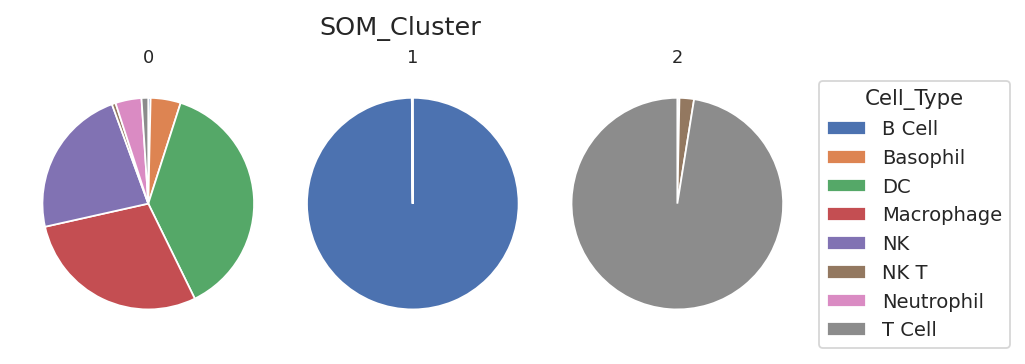

In [12]:
ex_som_count = flow.ChannelStatisticOp(name = "SOM_Count",
                                       channel = "FSC_A",
                                       function = len,
                                       by = ["SOM_Cluster", "Cell_Type"],
                                       subset = "Single_Cell == True & Live == True").apply(ex_som)

flow.MatrixView(statistic = "SOM_Count",
                style = "pie",
                variable = "Cell_Type",
                feature = "FSC_A",
                yfacet = "SOM_Cluster").plot(ex_som_count)

Well. We got three clusters -- one is mostly B cells, one is mostly T cells (with some NK and NK T cells), and one is "everything else" -- DCs, macrophages, basophils, neutrohpils. The reason we ended up with only three clusters here is because *most* of the cells in the data set are B and T cells! 

Can we do better? By default, the `SOMOp` operation uses consensus clustering to find the "natural" number of clusters -- but sometimes we want more resolution. Remember that *each* neuron in the self-organizing map actually defines a cluster, so the "natural" clusters are actually clusters of clusters!

You can disable the consensus clustering by setting the `consensus_cluster` attribute of the `SOMOp` to `False`. If you've already trained the SOM, you don't have to re-train it! Just call `update_consensus_clusters()` after changing `consensus_cluster` or any of the consensus clustering parameters, then call `apply()` again.

In [13]:
som_op.consensus_cluster = False
som_op.update_consensus_clusters()
ex_som = som_op.apply(ex_live)
ex_som.statistics["SOM_Cluster"]

,CD64,CD3,CD19,CD161,CD11c,MHCII,Ly_6G,CD11b,FcERI
SOM_Cluster,,,,,,,,,
0,0.226738,0.121663,0.711139,0.096507,0.176297,0.470379,0.228657,0.249910,0.142132
1,0.175665,0.259865,0.717535,0.093570,0.098668,0.535609,0.215967,0.163130,0.225028
2,0.206152,0.276354,0.702472,0.126244,0.224442,0.467791,0.252755,0.290158,0.174743
3,0.204389,0.142635,0.689291,0.169682,0.482463,0.546307,0.163354,0.303589,0.163733
4,0.352854,0.221938,0.699500,0.184988,0.325416,0.515196,0.189641,0.354996,0.394311
5,0.518091,0.279517,0.358920,0.257161,0.439005,0.520271,0.185274,0.531840,0.543711
6,0.204237,0.282069,0.247663,0.241629,0.717699,0.619190,0.172715,0.496648,0.229111
7,0.154476,0.121151,0.697525,0.155817,0.160260,0.576676,0.277737,0.271750,0.227268
8,0.219407,0.182614,0.694765,0.122287,0.213434,0.543111,0.224136,0.152105,0.107418


By default, `SOMOp` uses a 7x7 grid of neurons, so now we've got 49 clusters instead of 3. Let's recompute the count statistic from above:

In [14]:
ex_som_count = flow.ChannelStatisticOp(name = "SOM_Count",
                                       channel = "FSC_A",
                                       function = len,
                                       by = ["SOM_Cluster", "Cell_Type"],
                                       subset = "Single_Cell == True & Live == True").apply(ex_som)

This is quite a lot of clusters -- how can we make sense of them?

## Visualizing a self-organizing map with a minimum-spanning tree

Remember how the `SOMOp` module created a statistic with the clusters and their centers? (Of course you do -- it's two cells above this one.) Those cluster centers can be used to plot a *minimum spanning tree* (MST) that shows the clusters' relationships to eachother in high-dimensional space. We can use the `MSTView` view to create a MST. Note that the `SOM_Cluster` statistic is only used for the *locations* of each cluster in the tree. What gets plotted *at* those locations is *another* statistic -- in this case, the `SOM_Count` statistic that contains the number of events from each cell type in each cluster. We'll plot a pie chart at each location, which is a good way to visualize the relative abundance of each cell type in each cluster.

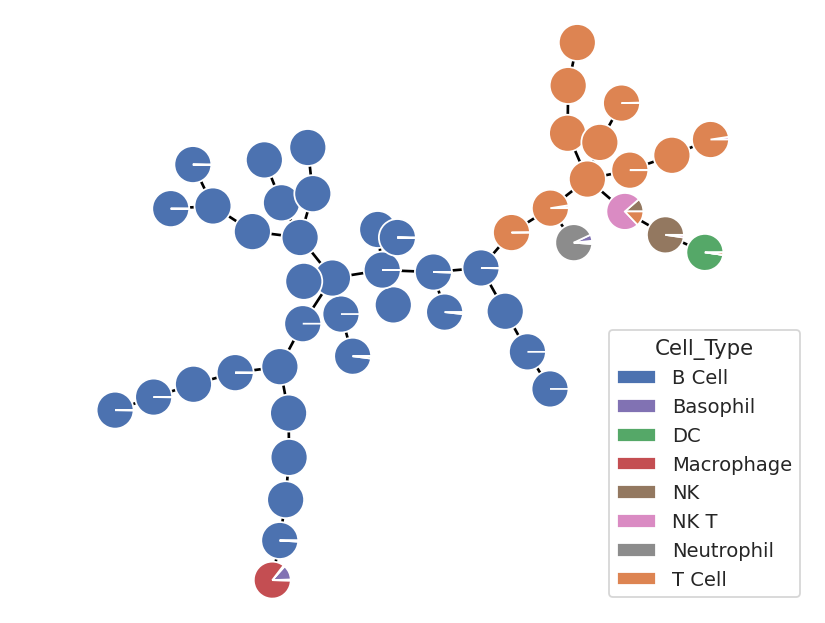

In [15]:
flow.MSTView(style = "pie",
             statistic = "SOM_Count",
             variable = "Cell_Type",
             feature = "FSC_A",
             locations = "SOM_Cluster",
             metric = 'euclidean').plot(ex_som_count)

That's a little more like it! Lots of T and B cells -- as expected -- but now, because we have a higher resolution "map" of the high-dimensional space, we can see that the other cell types are also clustering together! There are individual clusters of (mostly) NK, NK T, DC, Neutrophil, and macrophages. The only one missing its own cluster are the basophils -- and there are so few of them in this data set that that's not hugely surprising. Perhaps a SOM with more neurons would resolve them -- feel free to play around and find out!

Remember, though, that here we have the ground truth in this data set, and usually you won't. Let's use the *same tree* to plot *different data* -- in this case, the geometric mean of each of the 9 marker channels.

First, we need to create a new statistic. We'll used `FrameStatisticOp` to break the data set apart by different values of `SOM_Cluster`, then compute `flow.geom_mean()` on each channel in each subset.

In [16]:
op_marker_stat = flow.FrameStatisticOp(name = "SOM_Marker_Mean",
                                       by = ["SOM_Cluster"],
                                       function = lambda x: pd.Series({"CD64" : flow.geom_mean(x["CD64"]),
                                                                       "CD3" : flow.geom_mean(x["CD3"]),
                                                                       "CD19" : flow.geom_mean(x["CD19"]),
                                                                       "CD161" : flow.geom_mean(x["CD161"]),
                                                                       "CD11c" : flow.geom_mean(x["CD11c"]),
                                                                       "MHCII" : flow.geom_mean(x["MHCII"]),
                                                                       "Ly_6G" : flow.geom_mean(x["Ly_6G"]),
                                                                       "CD11b" : flow.geom_mean(x["CD11b"]),
                                                                       "FcERI" : flow.geom_mean(x["FcERI"])}),
                                      subset = "Single_Cell == True & Live == True")
ex_marker = op_marker_stat.apply(ex_som_count)

In [17]:
ex_marker.statistics["SOM_Marker_Mean"].head()

,CD64,CD3,CD19,CD161,CD11c,MHCII,Ly_6G,CD11b,FcERI
SOM_Cluster,,,,,,,,,
0,48.881560,-113.307490,13527.244066,-541.400374,-78.887474,1404.630782,68.391732,147.235850,-12.864664
1,-37.986999,123.798359,13706.225894,-556.902879,-294.634000,2751.383944,60.797191,-30.524994,80.620049
2,3.975231,168.311116,12865.033204,-371.834672,50.123072,1514.621438,148.298198,254.854666,20.959845
3,-23.783888,-39.767408,14540.616210,-102.483144,1896.639668,3792.009839,-25.314420,337.753416,34.470699
4,461.930846,41.467228,15011.048700,-88.127247,267.814390,2965.898558,23.121447,469.708267,702.696616


Now, we can use `MSTView` in a slightly different way. First, we'll make a "petal plot" instead of a pie plot at each location. And second, if we specify a statistic but not the variable from that statistic, the *columns* are used as the categories. (Was this functionality implemented for precisely this use case? Yes, yes it was.)

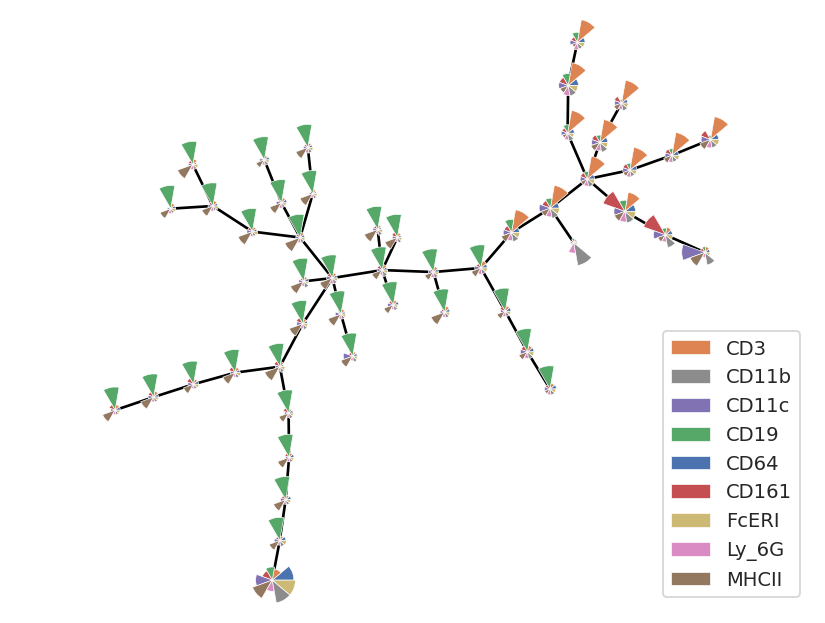

In [18]:
flow.MSTView(style = "petal",
             statistic = "SOM_Marker_Mean",
             locations = "SOM_Cluster").plot(ex_marker, lw = 0.3, radius = 0.035)

Now we can see that the fairly obvious classes of cells and their marker levels. High CD19 (and mostly low owther things) are B cells; high CD3 (and mostly low other things) are T cells. But there are a few clusters that are different, and those correspond to the other cell types.

## t-distributed Stochastic Neighbor Embedding

Self-organizing maps (and other clustering algorithms like K-means and FlowPeaks) are *classifiers* -- they take points in a high-dimensional space and sort them into bins based on a how close they are to eachother. These algorithms consider all of the dimensions -- in this case, all 9 of the channels -- but they are subject to the *curse of dimensionality* where increased numbers of dimensions make distance-based algorithms begin to fail.

Another approach is to reduce the number of dimensions, *embedding* the original high-dimensional data set into a lower-dimensional (usually 2) space. The trick is to do so in a way that retains the structure, keeping "close" observations in the higher-dimensional space still "close" in the lower-dimensional embedding.

t-distributed Stochastic Neighbor Embedding is an algorithm that promises to do just that. It is one of many non-linear dimensionality reduction methods -- its benefit over linear dimensionality reductions such as principal components analysis (PCA) is that is more faithfully maintains local structure.

This comes with a cost, of course, and that cost is computational complexity! On this fairly modest data set, the following cell takes over four minutes to run. So be patient! The results are worth it, I promise. The package we use, `openTSNE`, prints status updates so you don't get bored or think it's crashed. Also, the tSNE algorithm can also peform better or worse using different ways of measuring "distance" in the original high-dimensional space. For two or three channels, `euclidean` is fine, but for higher numbers of channels `cosine` seems to work better. Finally, this performs *much* better on scaled data, so we're using `logicle` for all of the channels. Just as with `SOMOp`, there are a number of parameters that can change the performance of the algorithm. Read the `tSNEop` class documentation for details.

In [19]:
tsne_op = flow.tSNEOp(name = "tSNE",
                      channels = ["CD64",
                                "CD3",
                                "CD19",
                                "CD161",
                                "CD11c",
                                "MHCII",
                                "Ly_6G",
                                "CD11b",
                                "FcERI"],
                      scale = {"CD64" : "logicle",
                               "CD3" : "logicle",
                               "CD19" : "logicle",
                               "CD161" : "logicle",
                               "CD11c" : "logicle",
                               "MHCII" : "logicle",
                               "Ly_6G" : "logicle",
                               "CD11b" : "logicle",
                               "FcERI" : "logicle"},
                      metric = "cosine")
tsne_op.estimate(ex_som_count)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='cosine', n_jobs=8, perplexity=10,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 30 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 0.20 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=198.25 for 250 iterations...
Iteration   50, KL divergence 4.6000, 50 iterations in 45.6969 sec
Iteration  100, KL divergence 4.5668, 50 iterations in 43.1384 sec
Iteration  150, KL divergence 4.5568, 50 iterations in 41.4098 sec
Iteration  200, KL divergence 4.5513, 50 iterations in 41.3300 sec
Iteration  250, KL divergence 4.5480, 50 iterations in 43.0481 sec
   --> Time elapsed: 214.62 seconds
===> Running optimizat

(If you saw an error about "No child process", don't worry about it -- it doesn't affect the outcome.)

Apply the operation, and note that it adds two more "channels" to the experiment -- named the same as the operation name, with `_1` and `_2` appended.

In [20]:
ex_tsne = tsne_op.apply(ex_som_count)
ex_tsne.data.head()

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 10.52 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.25 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 3948148.9583, 50 iterations in 2.9153 sec
Iteration  100, KL divergence 3915482.6764, 50 iterations in 2.7796 sec
Iteration  150, KL divergence 3895033.2699, 50 iterations in 2.8729 sec
Iteration  200, KL divergence 3880748.6666, 50 iterations in 2.8130 sec
Iteration  250, KL divergence 3869923.7153, 50 iterations in 2.9048 sec
   --> Time elapsed: 14.29 seconds


,CD161,Live_Dead,Ly_6G,AmCyan,CD11b,CD64,FcERI,Cell_Type,FSC_A,FSC_H,...,CD19,CD11c,Pacific_Blue,MHCII,Time,Single_Cell,Live,SOM_Cluster,tSNE_1,tSNE_2
0,867.849915,386.842163,79.696068,482.380005,-79.137207,169.278854,188.839493,B Cell,87030.718750,80358.0,...,14680.279297,-281.543640,127.491379,4268.340332,6968.700195,True,True,31,20.072726,-66.822968
1,327.388550,-175.940399,-89.582481,172.660004,51.409374,386.909424,334.144287,B Cell,96338.968750,87559.0,...,12738.702148,447.330078,-40.327629,1693.349609,5436.500000,True,False,4,-3.875199,-19.182361
2,493.974030,-180.421280,151.270081,281.239990,26.474604,-319.584473,375.361481,B Cell,95161.500000,88926.0,...,11745.514648,-80.861443,-76.268112,3642.938721,2477.199951,True,False,31,19.317669,-47.476411
3,-324.122528,-32.580925,-214.568588,140.619995,-46.702297,110.816521,-97.811043,B Cell,85820.492188,79845.0,...,13543.582031,98.451004,90.043648,2853.914062,1077.800049,True,True,11,37.330137,-14.398697
4,58.998810,4059.355469,-3.835757,125.489998,424.426666,-149.123917,266.677643,B Cell,44717.398438,40482.0,...,16535.718750,-282.773895,15.052464,3099.647705,2372.300049,True,False,30,34.690254,-33.893300


Let's plot the results, colored by "ground truth" cell type.

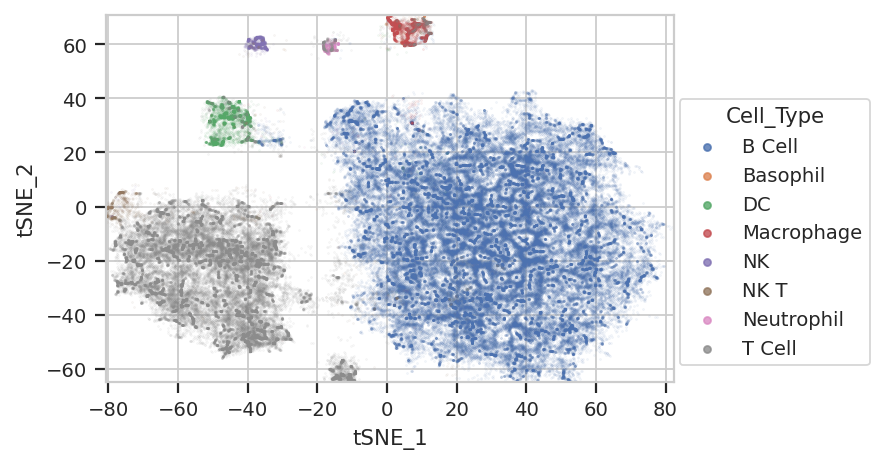

In [21]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huefacet = "Cell_Type").plot(ex_tsne, s = 0.1, alpha = 0.1)

Excellent! We're seeing "natural" clusters where (most) clusters seem to represent a single cell type. NK Ts are a little close to the T cells, and the basophils are hiding again, but the others seem to be relatively clearly clustered. 

...where are those sneaky basophils?

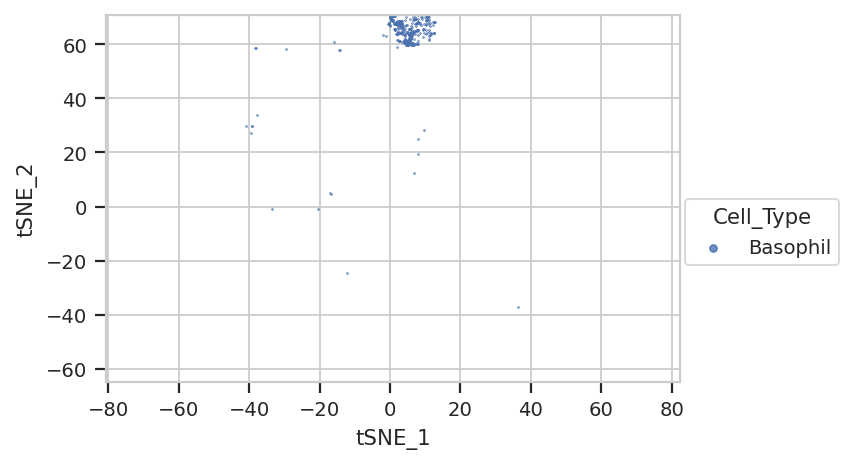

In [22]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huefacet = "Cell_Type", subset = "Cell_Type == 'Basophil'").plot(ex_tsne, s = 0.1, alpha = 1.0)

They're hiding with their friends, the macrophages!

Again, we usually won't have the ground truth -- so it's again good to evaluate the clusters by plotting the relative amounts of each marker in each cluster. The following graphs do so with the `huechannel` and `huescale` attributes of `ScatterplotView`, which relate the color of each event to the (scaled) value of a channel. And just as the source paper uses different color palettes for each different marker, so too here are different palettes with different vibes. The last, `viridis_r`, is my favorite and thus is the default if no palette is specified. For a comprehensive list of the options, see https://seaborn.pydata.org/tutorial/color_palettes.html and https://matplotlib.org/stable/users/explain/colors/colormaps.html

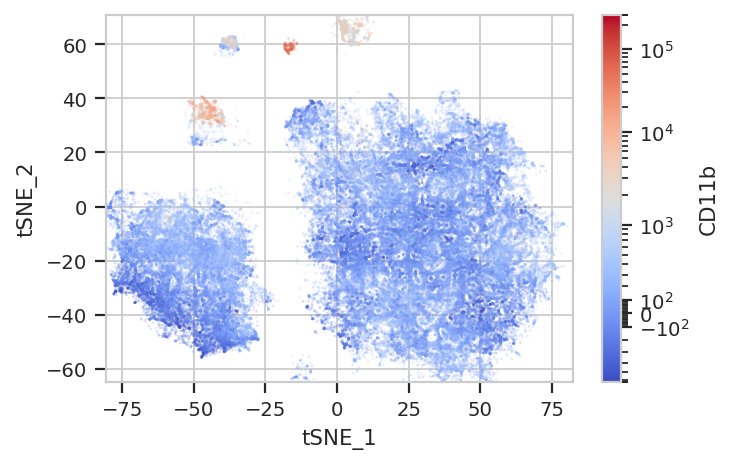

In [23]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "CD11b",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "coolwarm")

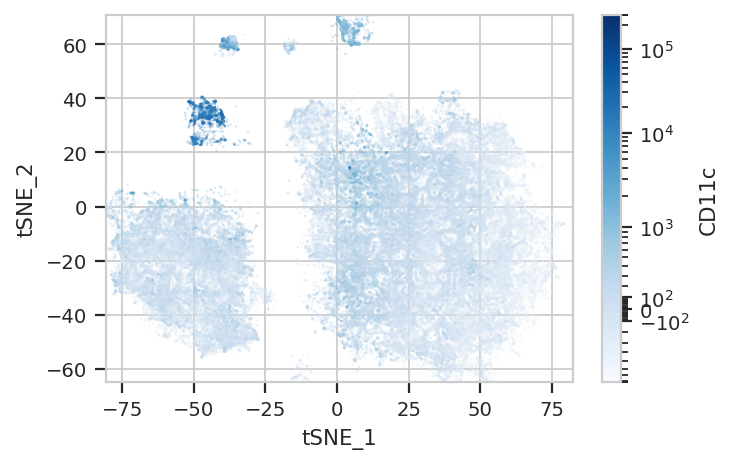

In [24]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "CD11c",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "Blues")

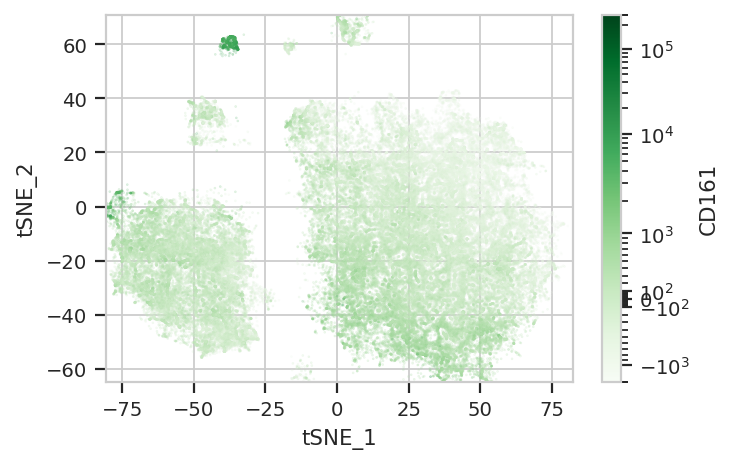

In [25]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "CD161",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "Greens")

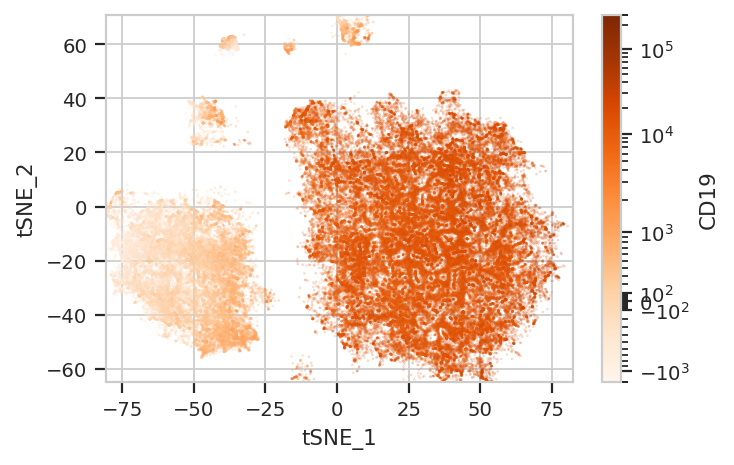

In [26]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "CD19",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "Oranges")

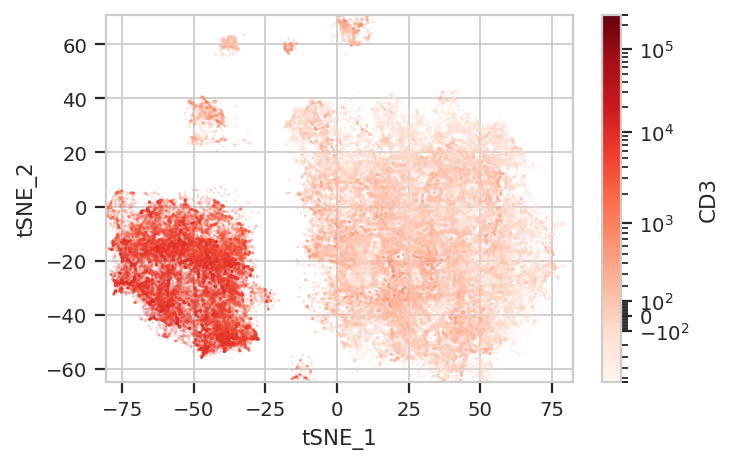

In [27]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "CD3",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "Reds")

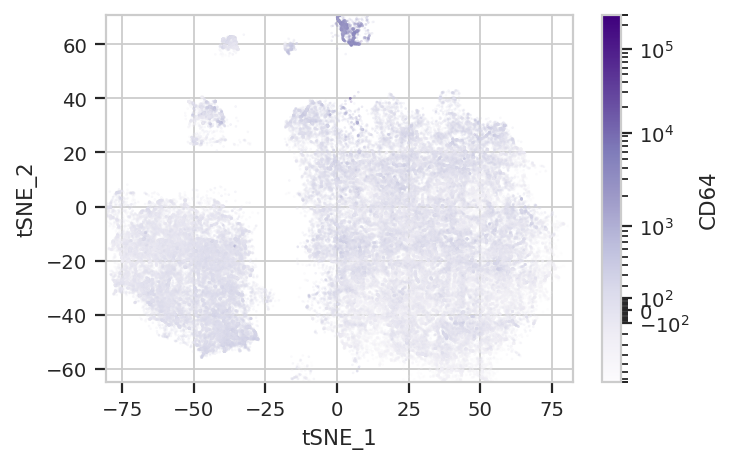

In [28]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "CD64",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "Purples")

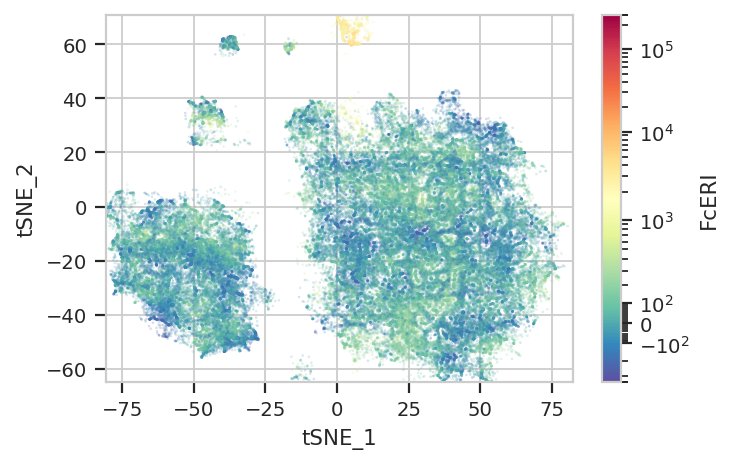

In [29]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "FcERI",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "Spectral_r")

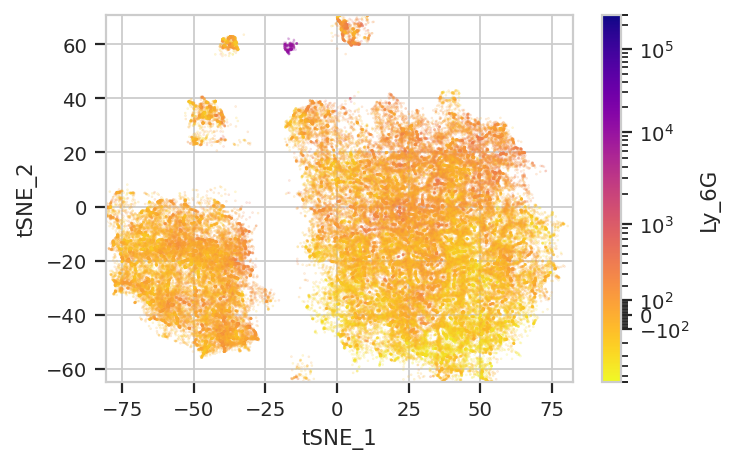

In [30]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "Ly_6G",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "plasma_r")

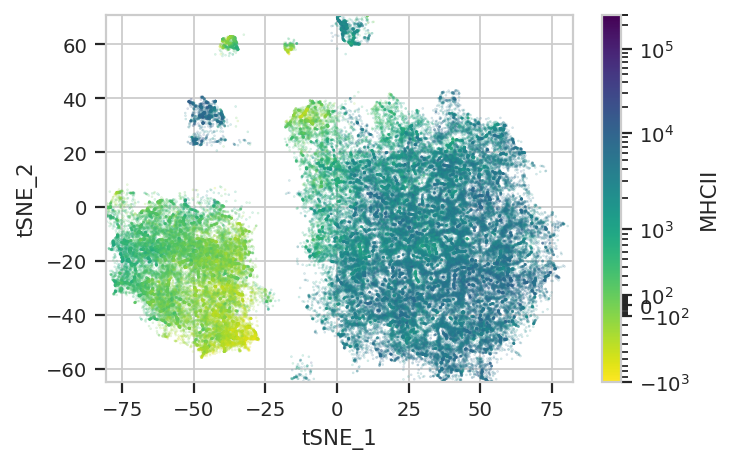

In [31]:
flow.ScatterplotView(xchannel = "tSNE_1",
                     ychannel = "tSNE_2",
                     huechannel = "MHCII",
                     huescale = "logicle",
                     subset = "Single_Cell == True & Live == True").plot(ex_tsne, s = 0.1, palette = "viridis_r")

Two final notes. First, because t-SNE is *stochastic*, and because it is initialized randomly, you will get a somewhat different plot each time you run it. This is expected behavior.

And second, there is a natural cluster in the tSNE plots that was assigned to the `T Cell` cell type using manual gating, but is definitely distinct from the main T cell blob on the tSNE plot. It is BOTH **CD19+** and **CD3+**. When you go back to look at the MST, they show up in a couple of clusters there too. I am not an immunologist, but Google thinks that this population should not exist. I don't know what it's doing there!